In [7]:
using Plots
using LES_ML
using LaTeXStrings
using CUDA
using Flux

In [68]:
N = (1024,1024)
UPC = 2       


x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

fine_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = true)

# number of unknowns per cell

J = (16,16) # compression in each direction
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)
0

FA_filter = gen_FA_filter(J,2) |> gpu


Conv((16, 16), 2 => 2, stride=16, bias=false)  # 1_024 parameters

In [69]:
forcing(x) = sin.(4*x[2])

F = fine_mesh.eval_function(forcing)
F = cat(F,cu(zeros(size(F))),dims = fine_mesh.dims + 1)



1024×1024×2×1 CuArray{Float32, 4, CUDA.DeviceMemory}:
[:, :, 1, 1] =
 0.0122712  0.036807  0.0613206  …  -0.0613206  -0.036807  -0.0122712
 0.0122712  0.036807  0.0613206     -0.0613206  -0.036807  -0.0122712
 0.0122712  0.036807  0.0613206     -0.0613206  -0.036807  -0.0122712
 0.0122712  0.036807  0.0613206     -0.0613206  -0.036807  -0.0122712
 0.0122712  0.036807  0.0613206     -0.0613206  -0.036807  -0.0122712
 0.0122712  0.036807  0.0613206  …  -0.0613206  -0.036807  -0.0122712
 0.0122712  0.036807  0.0613206     -0.0613206  -0.036807  -0.0122712
 0.0122712  0.036807  0.0613206     -0.0613206  -0.036807  -0.0122712
 0.0122712  0.036807  0.0613206     -0.0613206  -0.036807  -0.0122712
 0.0122712  0.036807  0.0613206     -0.0613206  -0.036807  -0.0122712
 ⋮                               ⋱                         
 0.0122712  0.036807  0.0613206  …  -0.0613206  -0.036807  -0.0122712
 0.0122712  0.036807  0.0613206     -0.0613206  -0.036807  -0.0122712
 0.0122712  0.036807  0.0613206

In [70]:
setup = gen_setup(fine_mesh)
setup_bar = gen_setup(coarse_mesh)

LES_ML.setup_struct(LES_ML.operators_struct(Conv((3, 3), 2 => 1, bias=false), Conv((3, 3), 1 => 2, bias=false), LES_ML.var"#C#86"{Float32, Int64}(0.09817477f0, Core.Box(Conv((3, 3), 2 => 4, bias=false)), Core.Box(Conv((3, 3), 2 => 4, bias=false)), 2, Core.Box(Conv((3, 3), 4 => 2, bias=false))), Conv((3, 3), 2 => 2, bias=false), Conv((3, 3), 2 => 1, bias=false)), LES_ML.var"#pressure_poisson#40"{LES_ML.var"#pressure_poisson#32#41", CuArray{Float32, 4, CUDA.DeviceMemory}}(LES_ML.var"#pressure_poisson#32#41"(Core.Box(2)), Core.Box(Float32[0.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]), Float32[1.0 0.999176 … 3.987152 0.9991913; 0.999176 1.9983826 … 4.9863586 1.9983978; … ; 3.987152 4.9863586 … 7.9743347 4.986374; 0.9991913 1.9983978 … 4.986374 1.9984131;;;;]), LES_ML.grid_swapper(LES_ML.mesh_struct(2, (64, 64), Float32[-3.0925052 -3.0925052 … -3.0925052 -3.0925052; -2.9943304 -2.9943304 … -2.9943304 -2.9943304; … ; 2.9943304 2.9943304 … 2.9943304 2.994330

In [72]:
max_k = 10
energy_norm = 1
number_of_simulations = 1
Re = 1000


KF_rhs = gen_rhs(setup,F;Re = Re,damping = 0.1)
coarse_KF_rhs = gen_rhs(setup_bar,FA_filter(F);Re = Re,damping = 0.1)

V = cu(gen_random_field(fine_mesh.N,max_k,norm = energy_norm,samples = (fine_mesh.UPC,number_of_simulations)))


    
MV = setup.O.M(padding(V,(1,1),circular = true))



p = setup.PS(MV)

Gp = setup.O.G(padding(p,(1,1),circular =true))

V0 = V-Gp

setup.O.M(V0)[:,:,1,1]

KF_rhs(V0,fine_mesh,0)


1024×1024×2×1 CuArray{Float32, 4, CUDA.DeviceMemory}:
[:, :, 1, 1] =
 0.509355  0.582334  0.656399  …   0.291725    0.362998     0.436532
 0.470745  0.544864  0.61985       0.252262    0.323925     0.397186
 0.432132  0.506704  0.581912      0.212101    0.284185     0.358593
 0.393005  0.468561  0.544005      0.171875    0.244306     0.318318
 0.35387   0.429044  0.506042      0.130688    0.203697     0.279264
 0.313533  0.390761  0.46731   …   0.0903249   0.163776     0.238259
 0.274332  0.350702  0.428357      0.049395    0.122354     0.198293
 0.233837  0.310793  0.389335      0.00862026  0.0822339    0.15738
 0.193907  0.271137  0.350079     -0.0326558   0.0408512    0.117037
 0.153634  0.230805  0.309841     -0.0741954   0.000238061  0.0762652
 ⋮                             ⋱                            
 0.830878  0.897988  0.965068  …   0.628463    0.696151     0.763743
 0.797515  0.865264  0.933306      0.593277    0.66103      0.729481
 0.763876  0.831563  0.900203      0.55719

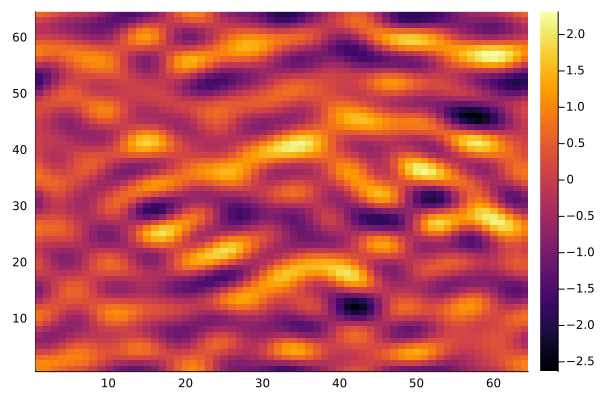

In [73]:
heatmap(Array(FA_filter(V0))[:,:,2,1])

In [75]:
dt = 0.001
save_every = 100
t_start = 0
t_end = 5
pre_allocate = true

t_data,sim_data = simulate(V0,fine_mesh,dt,t_start,t_end,KF_rhs,save_every = save_every,pre_allocate = pre_allocate) 
0

0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
2.0%┣█                                              ┫ 2/100 [00:00<00:13, 8it/s]
3.0%┣█▍                                            ┫ 3/100 [00:00<00:10, 10it/s]
4.0%┣█▉                                            ┫ 4/100 [00:00<00:08, 12it/s]
5.0%┣██▎                                           ┫ 5/100 [00:00<00:07, 13it/s]
7.0%┣███▏                                          ┫ 7/100 [00:00<00:06, 15it/s]
9.0%┣████▏                                         ┫ 9/100 [00:00<00:05, 17it/s]
11.0%┣████▉                                       ┫ 11/100 [00:01<00:05, 18it/s]
13.0%┣█████▊                                      ┫ 13/100 [00:01<00:05, 18it/s]
15.0%┣██████▋                                     ┫ 15/100 [00:01<00:05, 19it/s]
17.0%┣███████▌                                    ┫ 17/100 [00:01<00:04, 19it/s]
19.0%┣████████▍             

0

┌ Info: Saved animation to /gpfs/home6/tvangastelen/projects/LES_ML.jl/DNS_flow.gif
└ @ Plots /home/tvangastelen/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/gpfs/home6/tvangastelen/projects/LES_ML.jl/DNS_flow.gif")
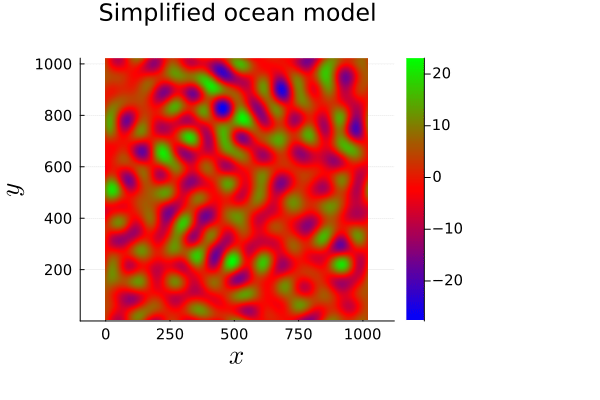

In [76]:
to_plot = Array(setup.O.w(sim_data[:,:,:,1,:]))[:,:,1,:]
#to_plot = setup_bar.O.w(pred_sim[:,:,1:2,:])[:,:,1,:]


ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "Simplified ocean model",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "DNS_flow.gif", fps = 30)

In [77]:
E = Array(fine_mesh.ip(sim_data,sim_data))[1:end]
E_bar = Array(coarse_mesh.ip(MP.FA_filter(sim_data[:,:,:,1,:]),MP.FA_filter(sim_data[:,:,:,1,:])))[1:end]

10-element Vector{Float32}:
 40.89733
 40.751453
 40.61039
 40.47414
 40.342705
 40.216087
 40.094284
 39.977303
 39.865135
 39.757782

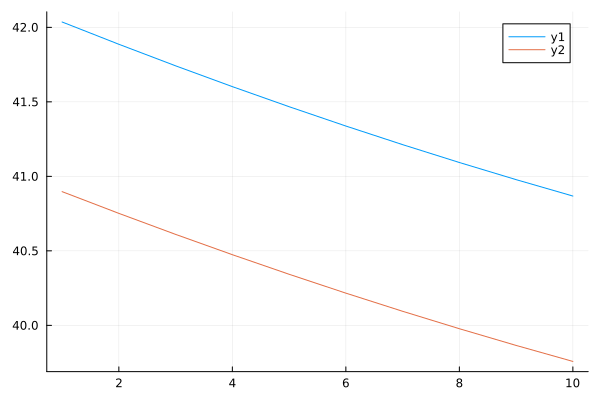

In [78]:
plot(E)
plot!(E_bar)

In [79]:
u = sim_data[:,:,:,1,:]
u_bar = FA_filter(u)

64×64×2×10 CuArray{Float32, 4, CUDA.DeviceMemory}:
[:, :, 1, 1] =
 -0.257165   -0.167384    -0.0793547  …  -0.313716    -0.363194   -0.333844
 -0.184827   -0.00743592   0.0870458     -0.616448    -0.587442   -0.41076
 -0.174669    0.0470044    0.143214      -0.851309    -0.761016   -0.487883
 -0.218614   -0.0256399    0.0481802     -0.949214    -0.822557   -0.526232
 -0.277659   -0.198286    -0.187656      -0.867833    -0.72661    -0.480917
 -0.298264   -0.397813    -0.493099   …  -0.632061    -0.480945   -0.329905
 -0.23264    -0.527045    -0.755052      -0.338637    -0.155689   -0.0891438
 -0.0580291  -0.501708    -0.861333      -0.115093     0.143355    0.191888
  0.208911   -0.290267    -0.750756      -0.0549613    0.322163    0.448332
  0.509863    0.0626621   -0.446951      -0.168138     0.34007     0.622145
  ⋮                                   ⋱                           
 -0.964391   -0.961335    -0.764746   …  -0.0388652   -0.380869   -0.738624
 -0.811552   -1.01158     -0.94

# Build all the closure models & check on conservative properties

In [80]:
r = 2 # output dimension
BC = "c"
channels = [5,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (1,1)
constrain_energy = true
conserve_momentum = true
use_GPU = true

skew_model = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum,use_GPU = use_GPU)
0

0

In [81]:
r = 2
BC = "c"
channels = [5,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (0,0)
constrain_energy = false
conserve_momentum = false

plain_model = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum,use_GPU = use_GPU)
0

0

In [82]:
r = 3
BC = "c"
channels = [5,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (0,0)
constrain_energy = false
conserve_momentum = false

div_NN = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum,use_GPU = use_GPU)

function div_model(input;mesh = coarse_mesh,NN = div_NN.eval,SO = SO)

    tau = NN(input)
    return divergence_model(tau,mesh,SO)
end
0

0

In [83]:
r = 1
BC = "c"
channels = [5,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (0,0)
constrain_energy = false
conserve_momentum = false


smag_NN = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum,use_GPU = use_GPU)

SO = gen_smagorinsky_operators(coarse_mesh)
Cs = cu([0.01])


function smag_model(input;mesh = coarse_mesh,NN = smag_NN.eval,SO = SO)
    dims = mesh.dims
    u_bar = input[[(:) for i in 1:dims]...,1:dims,:]
    Cs = NN(input)
    return smagorinsky_model(u_bar,mesh,Cs,SO)
end


function const_smag_model(input;mesh = coarse_mesh,Cs = Cs,SO = SO)
    dims = mesh.dims
    u_bar = input[[(:) for i in 1:dims]...,1:dims,:]
    return smagorinsky_model(u_bar,mesh,Cs,SO)
end
0

0

In [84]:
const_smag_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = const_smag_model) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model)
smag_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = smag_model) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model)
div_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = div_model) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model)
plain_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = plain_model.eval) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model)
skew_rhs(u_bar,mesh,t;setup= setup_bar,rhs = coarse_KF_rhs,Re = Re,model = skew_model.eval,B = skew_model.B) = neural_rhs(u_bar,mesh,t;setup= setup,rhs = rhs,Re = Re,model = model,B=B)

skew_rhs (generic function with 1 method)

In [86]:
using LES_ML

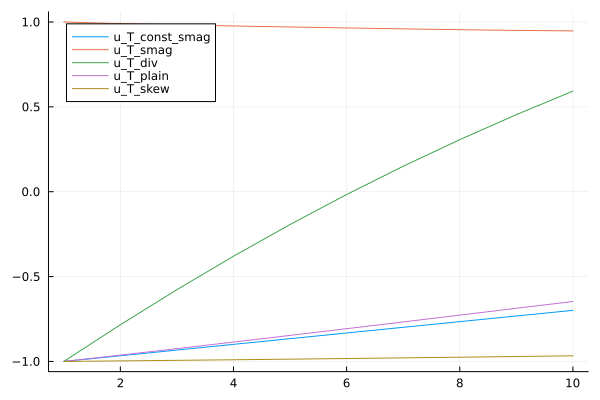

In [88]:
u_T_const_smag = Array(coarse_mesh.ip(const_smag_rhs(u_bar,coarse_mesh,0),u_bar))
u_T_smag = Array(coarse_mesh.ip(smag_rhs(u_bar,coarse_mesh,0),u_bar))
u_T_div = Array(coarse_mesh.ip(div_rhs(u_bar,coarse_mesh,0),u_bar))
u_T_plain = Array(coarse_mesh.ip(plain_rhs(u_bar,coarse_mesh,0),u_bar))
u_T_skew = Array(coarse_mesh.ip(skew_rhs(u_bar,coarse_mesh,0),u_bar))

u_T_const_smag = plot(u_T_const_smag[1:end] ./ maximum(abs.(u_T_const_smag[1:end])),label = "u_T_const_smag")
u_T_smag = plot!(u_T_smag[1:end] ./ maximum(abs.(u_T_smag[1:end])),label = "u_T_smag")
u_T_div = plot!(u_T_div[1:end] ./ maximum(abs.(u_T_div[1:end])),label = "u_T_div")
u_T_plain = plot!(u_T_plain[1:end] ./ maximum(abs.(u_T_plain[1:end])),label = "u_T_plain")
u_T_skew = plot!(u_T_skew[1:end] ./ maximum(abs.(u_T_skew[1:end])),label = "u_T_skew")



In [89]:
save_NN_model(skew_model,"models/skew_model")
save_NN_model(plain_model,"models/plain_model")
save_NN_model(div_NN,"models/div_NN")
save_NN_model(smag_NN,"models/smag_NN")


skew_model = load_NN_model("models/skew_model",use_GPU = use_GPU)
plain_model = load_NN_model("models/plain_model",use_GPU = use_GPU)
div_NN = load_NN_model("models/div_NN",use_GPU = use_GPU)
smag_NN = load_NN_model("models/smag_NN",use_GPU = use_GPU)

0


Model saved at directory [models/skew_model]

Model saved at directory [models/plain_model]

Model saved at directory [models/div_NN]

Model saved at directory [models/smag_NN]

Model loaded from directory [models/skew_model]

Model loaded from directory [models/plain_model]

Model loaded from directory [models/div_NN]

Model loaded from directory [models/smag_NN]


0

In [90]:
c = (FA_filter(KF_rhs(u,fine_mesh,0)) - coarse_KF_rhs(u_bar,coarse_mesh,0))

64×64×2×10 CuArray{Float32, 4, CUDA.DeviceMemory}:
[:, :, 1, 1] =
 -0.112348    0.0259861    0.134209   …  -0.014902    -0.115503   -0.174556
 -0.0605537   0.0980482    0.187774       0.00736451  -0.0938002  -0.153219
 -0.0461136   0.107285     0.228682      -0.00895357  -0.108731   -0.140513
 -0.139483   -0.0193253    0.204624      -0.0174052   -0.118076   -0.155583
 -0.247784   -0.224054     0.0889305      0.00582826  -0.0515588  -0.111579
 -0.221563   -0.356576    -0.0714264  …  -0.00257396   0.059071    0.042706
 -0.0611275  -0.336794    -0.200411      -0.0904682    0.0863847   0.196364
  0.0897174  -0.217488    -0.265313      -0.199266    -0.0377869   0.190165
  0.14213    -0.0928302   -0.290009      -0.233302    -0.216259    0.0370154
  0.143374    0.00255227  -0.293898      -0.160612    -0.28007    -0.0903687
  ⋮                                   ⋱                           
  0.342373    0.323834     0.0262121  …  -0.167831     0.120956    0.228338
  0.0370629   0.0917734   -0.

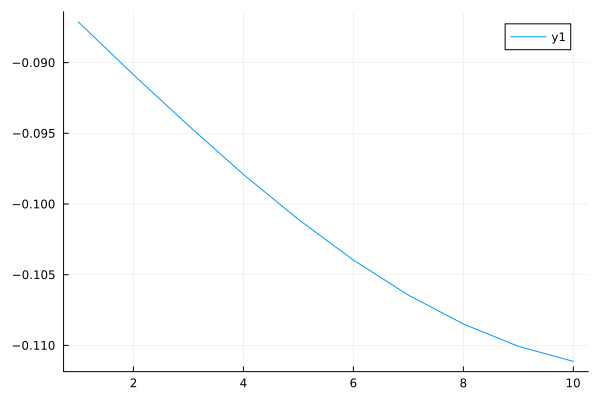

In [91]:
closure_energy = coarse_mesh.ip(c,u_bar)
#closure_energy = coarse_mesh.ip(c,u_bar)
plot(Array(closure_energy)[1:end])